In [0]:
!pip install -q keras
import keras

In [0]:
import os
from skimage import io
import numpy as np
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, DepthwiseConv2D
from keras.layers import Concatenate
from keras.models import load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 100
l = 33 # no of layers in dense block
num_filter = 12 # growth rate k
compression = 1.0

__LOAD CIFAR10 DATA__<br>
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, <br>with 6000 images per class. There are 50000 training images and 10000 <br>test images.

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

__PREPROCESSING DATA__

In [0]:
#https://gist.github.com/A-Jatin/5319db311385f395600c28a54f56fdbf
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

__DATA AUGMENTATION__<br>
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [0]:
# Data augementation
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.25,
    height_shift_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.10
)

datagen_train.fit(x_train)

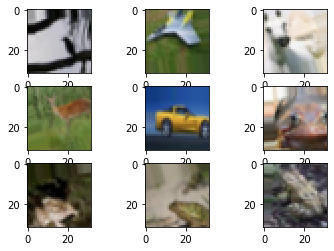

In [63]:
for X_batch, y_batch in datagen_train.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    plt.show()
    break

__DENSENET WITHOUT USING DROPOUT AND DENSE LAYER__

In [0]:
# Dense Block
def add_denseblock(input, num_filter =12):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        temp = concat
    return temp


In [0]:
def add_transition(input, num_filter = 12):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    reshape=keras.layers.Reshape((816,1))(flat)
    conv1D=keras.layers.Conv1D(num_filter,(31,),use_bias=False,padding='same')(reshape)
    AvgPooling1D = keras.layers.AveragePooling1D(pool_size=(81,))(reshape)
    output= keras.layers.Flatten()(AvgPooling1D)
    return output


In [0]:
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter)
First_Transition = add_transition(First_Block, num_filter)

Second_Block = add_denseblock(First_Transition, num_filter)
Second_Transition = add_transition(Second_Block, num_filter)

Third_Block = add_denseblock(Second_Transition, num_filter)
Third_Transition = add_transition(Third_Block, num_filter)

Last_Block = add_denseblock(Third_Transition,  num_filter)
output = output_layer(Last_Block)

In [76]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_409 (Conv2D)             (None, 32, 32, 6)    162         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_409 (BatchN (None, 32, 32, 6)    24          conv2d_409[0][0]                 
__________________________________________________________________________________________________
activation_409 (Activation)     (None, 32, 32, 6)    0           batch_normalization_409[0][0]    
____________________________________________________________________________________________

In [0]:
import warnings
warnings.filterwarnings("ignore")
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),#SGD(lr=0.1, momentum=0.9, decay=0.0001, nesterov=True),
              metrics=['accuracy'])

In [19]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://82d5cd90.ngrok.io


In [0]:
filepath = "{epoch:03d}-{val_acc:.3f}.hdf5"
model_chkpt = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, verbose = 1)

__I am Saving model manually and with checkpoint also<br> 
because main reason is sometimes colab notebook gets disconnected and <br>
sometimes my accuraccy may gets decreased__<br>
https://machinelearningmastery.com/check-point-deep-learning-models-keras/

In [0]:
%%time
history = model.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=batch_size),
    epochs=10,
    verbose = 1,
    validation_data=(x_test, y_test),
    callbacks = [model_chkpt,TensorBoardColabCallback(tbc)]
)

Epoch 1/10
782/782 [==============================] - 579s 740ms/step - loss: 1.6038 - acc: 0.4087 - val_loss: 1.3461 - val_acc: 0.5051

Epoch 00001: val_loss improved from inf to 1.34607, saving model to 001-0.505.hdf5

Epoch 2/10
782/782 [==============================] - 571s 730ms/step - loss: 1.3022 - acc: 0.5278 - val_loss: 1.6137 - val_acc: 0.5080

Epoch 00002: val_loss did not improve from 1.34607
Epoch 3/10
782/782 [==============================] - 571s 730ms/step - loss: 1.1557 - acc: 0.5829 - val_loss: 1.1635 - val_acc: 0.6049

Epoch 00003: val_loss improved from 1.34607 to 1.16351, saving model to 003-0.605.hdf5
Epoch 4/10
782/782 [==============================] - 572s 731ms/step - loss: 1.0578 - acc: 0.6188 - val_loss: 1.0102 - val_acc: 0.6519

Epoch 00004: val_loss improved from 1.16351 to 1.01017, saving model to 004-0.652.hdf5
Epoch 5/10
782/782 [==============================] - 572s 731ms/step - loss: 0.9749 - acc: 0.6520 - val_loss: 1.4085 - val_acc: 0.5784

Epoch 

In [0]:
model.save('my_model_10.h5')

In [0]:
link= 'https://drive.google.com/open?id=1Yyk_kUn6x-fPtX1VQMHdQenGxd6Kf0_v'

In [14]:
fluff, id = link.split('=')
print (id)

1Yyk_kUn6x-fPtX1VQMHdQenGxd6Kf0_v


In [0]:
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('my_model_10.h5')

__first i train for 10 epochs and save the model and start to execute the model from that epoch only__ 

In [0]:
# Recreate the exact same model, including weights and optimizer.
conti_model = keras.models.load_model('my_model_10.h5')

In [21]:
%%time
history = conti_model.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=batch_size),
    epochs=20,
    verbose = 1,
    validation_data=(x_test, y_test),
    callbacks = [model_chkpt,TensorBoardColabCallback(tbc)]
)



Epoch 1/20
782/782 [==============================] - 270s 346ms/step - loss: 0.7076 - acc: 0.7536 - val_loss: 0.8814 - val_acc: 0.7143

Epoch 00001: val_loss improved from inf to 0.88139, saving model to 001-0.714.hdf5

Epoch 2/20
782/782 [==============================] - 227s 291ms/step - loss: 0.6836 - acc: 0.7603 - val_loss: 0.8617 - val_acc: 0.7224

Epoch 00002: val_loss improved from 0.88139 to 0.86172, saving model to 002-0.722.hdf5
Epoch 3/20
782/782 [==============================] - 227s 290ms/step - loss: 0.6561 - acc: 0.7722 - val_loss: 0.6473 - val_acc: 0.7727

Epoch 00003: val_loss improved from 0.86172 to 0.64726, saving model to 003-0.773.hdf5
Epoch 4/20
782/782 [==============================] - 228s 291ms/step - loss: 0.6405 - acc: 0.7757 - val_loss: 0.7398 - val_acc: 0.7573

Epoch 00004: val_loss did not improve from 0.64726
Epoch 5/20
782/782 [==============================] - 225s 288ms/step - loss: 0.6192 - acc: 0.7834 - val_loss: 0.7869 - val_acc: 0.7404

Epoc

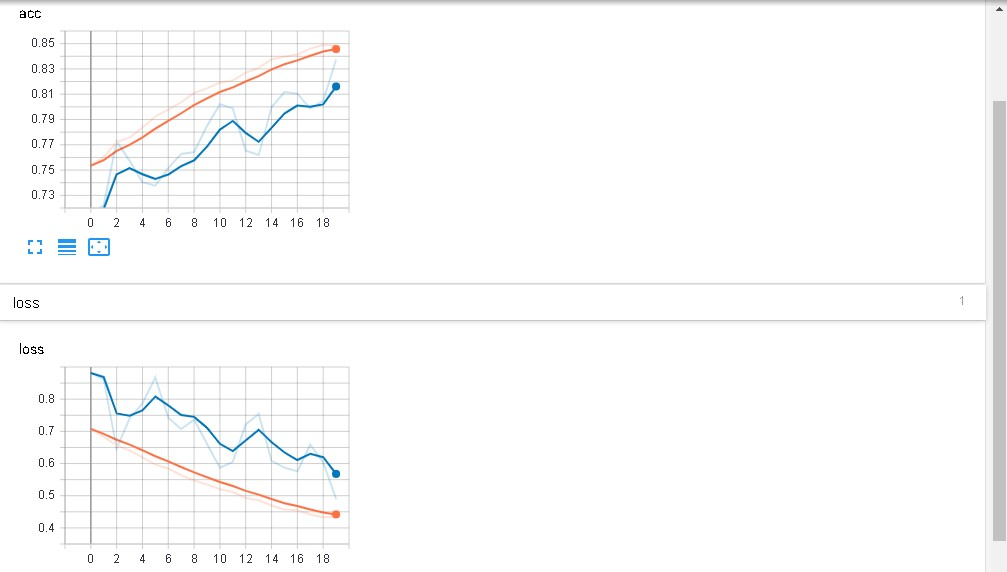

In [2]:
from IPython.display import Image
Image('30.jpg')

__you can see my train and test graph after 30 epochs__

__-----------------------------------------------------------------------------------------------------------------------__

In [0]:
conti_model.save('my_model_30.h5')

In [25]:
uploaded = drive.CreateFile({'title': 'my_model_30.h5'})
uploaded.SetContentFile('my_model_30.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1n1x0QYnG822xYTbEJlrTWVb_7hEeIWZN


__this is just saving and loading of model for particular epochs__

In [0]:
# Recreate the exact same model, including weights and optimizer.
conti_model_60 = keras.models.load_model('my_model_30.h5')

In [29]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://45a0dd45.ngrok.io


In [0]:
filepath = "{epoch:03d}-{val_acc:.3f}.hdf5"
model_chkpt = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, verbose = 1)

In [31]:
%%time
history = conti_model_50.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=batch_size),
    epochs=30,
    verbose = 1,
    validation_data=(x_test, y_test),
    callbacks = [model_chkpt,TensorBoardColabCallback(tbc)]
)

Epoch 1/30
782/782 [==============================] - 272s 347ms/step - loss: 0.4187 - acc: 0.8551 - val_loss: 0.4378 - val_acc: 0.8531

Epoch 00001: val_loss improved from inf to 0.43780, saving model to 001-0.853.hdf5
Epoch 2/30
782/782 [==============================] - 237s 303ms/step - loss: 0.4162 - acc: 0.8543 - val_loss: 0.5080 - val_acc: 0.8347

Epoch 00002: val_loss did not improve from 0.43780
Epoch 3/30
782/782 [==============================] - 234s 300ms/step - loss: 0.4037 - acc: 0.8592 - val_loss: 0.4948 - val_acc: 0.8354

Epoch 00003: val_loss did not improve from 0.43780
Epoch 4/30
782/782 [==============================] - 234s 299ms/step - loss: 0.3966 - acc: 0.8618 - val_loss: 0.6414 - val_acc: 0.7961

Epoch 00004: val_loss did not improve from 0.43780
Epoch 5/30
782/782 [==============================] - 236s 302ms/step - loss: 0.3928 - acc: 0.8613 - val_loss: 0.5571 - val_acc: 0.8238

Epoch 00005: val_loss did not improve from 0.43780
Epoch 6/30
782/782 [========

__My graph after 60 epochs__

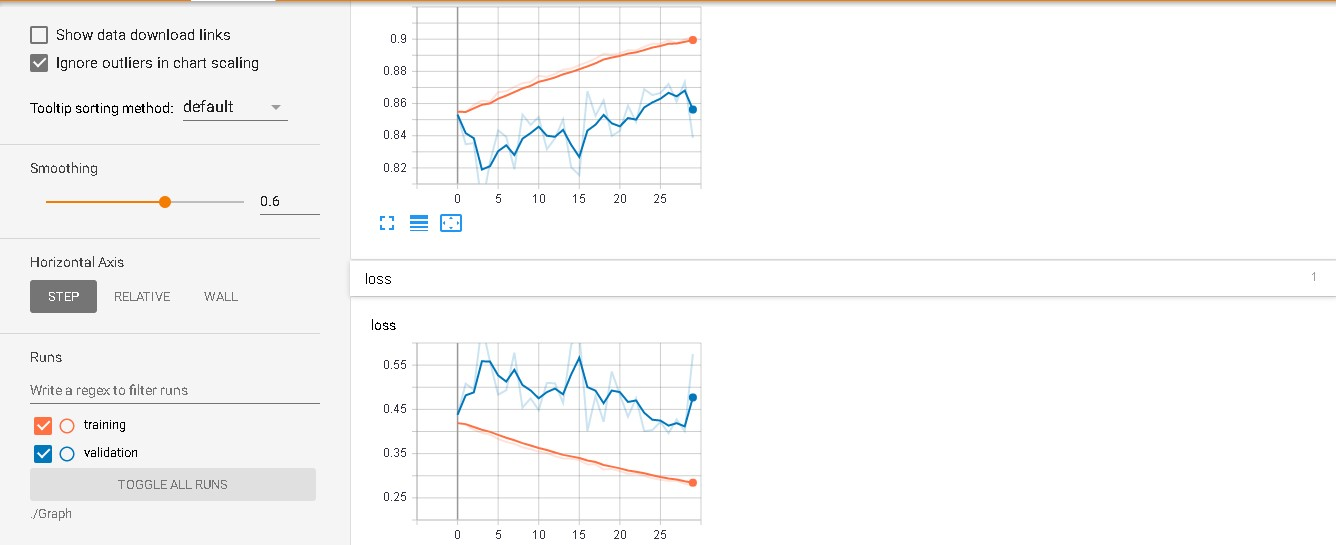

In [3]:
from IPython.display import Image
Image('60.jpg')

__------------------------------------------------------------------------------------------------------------------__

In [0]:
conti_model_60.save('my_model_60.h5')

In [35]:
uploaded = drive.CreateFile({'title': 'my_model_50.h5'})
uploaded.SetContentFile('my_model_60.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1Xv3aavR5wXxTzw8DLfGhA_GB2n4uozI7


In [0]:
# Recreate the exact same model, including weights and optimizer.
conti_model_80 = keras.models.load_model('my_model_60.h5')

In [38]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://21d37c91.ngrok.io


In [0]:
filepath = "{epoch:03d}-{val_acc:.3f}.hdf5"
model_chkpt = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, verbose = 1)

In [41]:
%%time
history = conti_model_70.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=batch_size),
    epochs=20,
    verbose = 1,
    validation_data=(x_test, y_test),
    callbacks = [model_chkpt,TensorBoardColabCallback(tbc)]
)

Epoch 1/20
782/782 [==============================] - 279s 356ms/step - loss: 0.2779 - acc: 0.9021 - val_loss: 0.5569 - val_acc: 0.8371

Epoch 00001: val_loss improved from inf to 0.55687, saving model to 001-0.837.hdf5
Epoch 2/20
782/782 [==============================] - 234s 299ms/step - loss: 0.2754 - acc: 0.9032 - val_loss: 0.4740 - val_acc: 0.8553

Epoch 00002: val_loss improved from 0.55687 to 0.47397, saving model to 002-0.855.hdf5
Epoch 3/20
782/782 [==============================] - 235s 301ms/step - loss: 0.2634 - acc: 0.9088 - val_loss: 0.4918 - val_acc: 0.8526

Epoch 00003: val_loss did not improve from 0.47397
Epoch 4/20
782/782 [==============================] - 225s 288ms/step - loss: 0.2669 - acc: 0.9065 - val_loss: 0.4954 - val_acc: 0.8504

Epoch 00004: val_loss did not improve from 0.47397
Epoch 5/20
782/782 [==============================] - 225s 288ms/step - loss: 0.2628 - acc: 0.9075 - val_loss: 0.4552 - val_acc: 0.8622

Epoch 00005: val_loss improved from 0.47397

__graph AFTER 80 epochs__

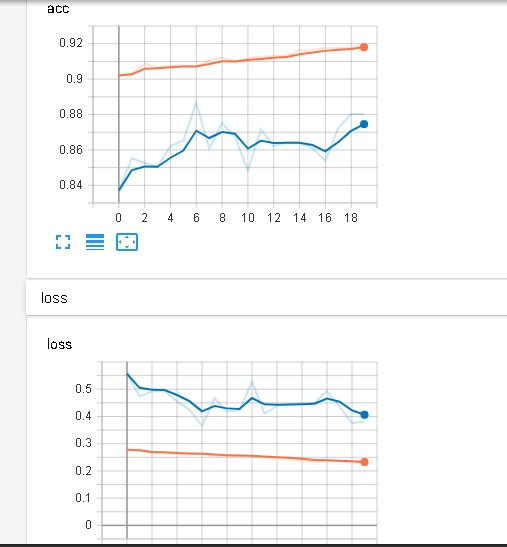

In [4]:
from IPython.display import Image
Image('80.jpg')

__----------------------------------------------------------------------------------------------------------------__

In [0]:
conti_model_80.save('my_model_80.h5')

In [44]:
uploaded = drive.CreateFile({'title': 'my_model_80.h5'})
uploaded.SetContentFile('my_model_80.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1JMhmK45fHP_-UIGz6tMJXwPiwyNuIQha


In [0]:
# Recreate the exact same model, including weights and optimizer.
conti_model_100 = keras.models.load_model('my_model_80.h5')

In [46]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://638ea18d.ngrok.io


In [0]:
filepath = "{epoch:03d}-{val_acc:.3f}.hdf5"
model_chkpt = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, verbose = 1)

In [48]:
%%time
history = conti_model_90.fit_generator(
    datagen_train.flow(x_train, y_train, batch_size=batch_size),
    epochs=20,
    verbose = 1,
    validation_data=(x_test, y_test),
    callbacks = [model_chkpt,TensorBoardColabCallback(tbc)]
)

Epoch 1/20
782/782 [==============================] - 287s 367ms/step - loss: 0.2293 - acc: 0.9179 - val_loss: 0.4259 - val_acc: 0.8690

Epoch 00001: val_loss improved from inf to 0.42593, saving model to 001-0.869.hdf5
Epoch 2/20
782/782 [==============================] - 236s 302ms/step - loss: 0.2232 - acc: 0.9206 - val_loss: 0.4427 - val_acc: 0.8682

Epoch 00002: val_loss did not improve from 0.42593
Epoch 3/20
782/782 [==============================] - 235s 300ms/step - loss: 0.2242 - acc: 0.9220 - val_loss: 0.5434 - val_acc: 0.8436

Epoch 00003: val_loss did not improve from 0.42593
Epoch 4/20
782/782 [==============================] - 236s 301ms/step - loss: 0.2222 - acc: 0.9237 - val_loss: 0.4061 - val_acc: 0.8749

Epoch 00004: val_loss improved from 0.42593 to 0.40614, saving model to 004-0.875.hdf5
Epoch 5/20
782/782 [==============================] - 235s 301ms/step - loss: 0.2202 - acc: 0.9230 - val_loss: 0.3796 - val_acc: 0.8840

Epoch 00005: val_loss improved from 0.40614

In [0]:
conti_model_90.load_weights('016-0.892.hdf5')

In [56]:
score = conti_model_90.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 12s 1ms/step
Test loss: 0.3610185995578766
Test accuracy: 0.8993


In [11]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["TRAIN", "TEST"]

x.add_row([92.79, 89.93 ])
print(x)

+-------+-------+
| TRAIN |  TEST |
+-------+-------+
| 92.79 | 89.93 |
+-------+-------+


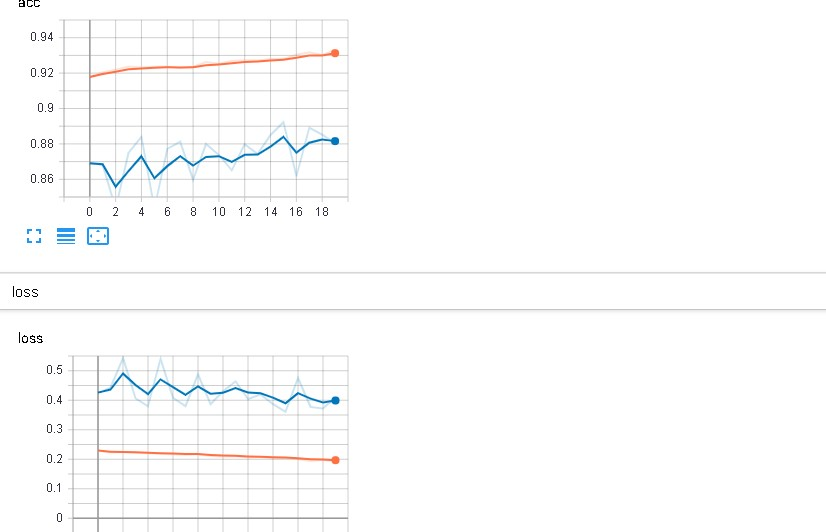

In [5]:
from IPython.display import Image
Image('100.jpg')

__GRAPH AFTER 100 epochs__

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Test Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

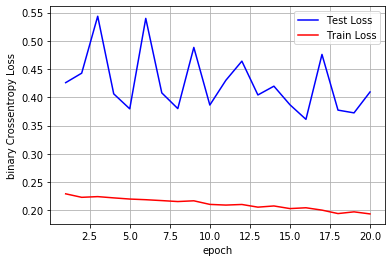

In [84]:

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary Crossentropy Loss')

# list of epoch numbers
x = list(range(1,20+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs


vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

1. I run the model for 100 epochs 
2. actually the notebooks gets disconnected in between thats why i run the model in parts.
3. After 100 epochs i tried but my model test perfomance was decreasing thats why i have to stop .
4. the highest accuracy for test which i get is 89.9 .
5. After each part i plot the visualization of tensorboard colab.

<h1>END<h1>